## CIFAR10 classifier

Using simple 2-layer neural network and SGD + Momentum

In [2]:
%pylab inline

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


Populating the interactive namespace from numpy and matplotlib


In [3]:
from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme


CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}), 
    (Flatten, [], {'which_sources': 'features'}),
    (Mapping, [lambda batch: (b.T for b in batch)], {})
)

In [4]:
cifar10_train = CIFAR10(("train",), subset=slice(None, 40000))

#this stream will shuffle the CIFAR10 set and return us batches of 100 examples
cifar10_train_stream = DataStream.default_stream(
    cifar10_train,
    iteration_scheme=ShuffledScheme(cifar10_train.num_examples, 100)
)

cifar10_validation = CIFAR10(("train",), subset=slice(40000, None))

In [5]:
# We will use larger portions for testing and validation
# as these dont do a backward pass and reauire less RAM.
cifar10_validation_stream = DataStream.default_stream(
    cifar10_validation, 
    iteration_scheme=SequentialScheme(cifar10_validation.num_examples, 250)
)

cifar10_test = CIFAR10(("test",))
cifar10_test_stream = DataStream.default_stream(
    cifar10_test,
    iteration_scheme=SequentialScheme(cifar10_test.num_examples, 250)
)

In [6]:
print "The streams return batches containing %s" % (cifar10_train_stream.sources,)

print "Each trainin batch consits of a tuple containing:"
for element in next(cifar10_train_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)
    
print "Validation/test batches consits of tuples containing:"
for element in next(cifar10_test_stream.get_epoch_iterator()):
    print " - an array of size %s containing %s" % (element.shape, element.dtype)

The streams return batches containing (u'features', u'targets')
Each trainin batch consits of a tuple containing:
 - an array of size (3072, 100) containing float32
 - an array of size (1, 100) containing uint8
Validation/test batches consits of tuples containing:
 - an array of size (3072, 250) containing float32
 - an array of size (1, 250) containing uint8


In [7]:
# cifar10_train = CIFAR10(("train",), subset=slice(None,40000))
# cifar10_validation = CIFAR10(("train",), subset=slice(40000, None))
# cifar10_test = CIFAR10(("test",))

# print("We have %d training, %d validation, and %d test examples" % (
#     cifar10_train.num_examples, cifar10_validation.num_examples, cifar10_test.num_examples))

# print("The examples are pairs of %s:" % (cifar10_train.sources,))
# for i, source in enumerate(cifar10_train.sources):
#     labels = cifar10_train.axis_labels[source]
#     print('The source #%d named "%s" is a %dd array with axis: %s' % (
#         i, source, len(labels), labels))

# cifar10_train_X = (cifar10_train.data_sources[0].reshape(cifar10_train.num_examples, -1) / 255.0).astype(np.single)
# cifar10_train_Y = cifar10_train.data_sources[1].ravel()

# cifar10_valid_X = (cifar10_validation.data_sources[0].reshape(cifar10_validation.num_examples, -1) / 255.0).astype(np.single)
# cifar10_valid_Y = cifar10_validation.data_sources[1].ravel()

In [8]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)

In [9]:
class Layer(object):
    def __init__(self, rng=None):
        if rng is None:
            rng = numpy.random
        self.rng = rng
    
    @property
    def parameters(self):
        return []
    
    @property
    def parameter_names(self):
        return []
    
    def get_gradients(self, dLdY, fprop_context):
        return []
    

class AffineLayer(Layer):
    def __init__(self, num_in, num_out, weight_init=None, bias_init=None, **kwargs):
        super(AffineLayer, self).__init__(**kwargs)
        if weight_init is None:
            #
            # TODO propose a default initialization scheme.
            # Type a sentence explaining why, and if you use a reference, 
            # cite it here
            #
            weight_init = IsotropicGaussian()
        if bias_init is None:
            bias_init = Constant(0.0)
        
        self.W = weight_init.generate(self.rng, (num_out, num_in))
        self.b = bias_init.generate(self.rng, (num_out, 1))
    
    @property
    def parameters(self):
        return [self.W, self.b]
    
    @property
    def parameter_names(self):
        return ['W','b']
    
    def fprop(self, X):
        #Save X for later reusal
        fprop_context = dict(X=X)
        Y = np.dot(self.W, X) +  self.b
        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        #
        # TODO: fill in gradient computation
        #
        dLdX = (self.W.T).dot(dLdY)
        return dLdX
    
    def get_gradients(self, dLdY, fprop_context):
        X = fprop_context['X']
        dLdW = np.dot(dLdY, X.T)
        dLdb = dLdY.sum(1, keepdims=True)
        return [dLdW, dLdb]
    
class TanhLayer(Layer):
    def __init__(self, **kwargs):
        super(TanhLayer, self).__init__(**kwargs)
    
    def fprop(self, X):
        Y = np.tanh(X)
        fprop_context = dict(Y=Y)
        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        Y = fprop_context['Y']
        #
        # Fill in proper gradient computation
        #
        return dLdY * (1 - Y**2)

    
class ReLULayer(Layer):
    def __init__(self, **kwargs):
        super(ReLULayer, self).__init__(**kwargs)
    
    def fprop(self, X):
        Y = np.maximum(X, 0.0)
        fprop_context = dict(Y=Y)
        return Y, fprop_context
    
    def bprop(self, dLdY, fprop_context):
        Y = fprop_context['Y']
        return dLdY * (Y>0)

    
class SoftMaxLayer(Layer):
    def __init__(self, **kwargs):
        super(SoftMaxLayer, self).__init__(**kwargs)
    
    def compute_probabilities(self, X):
        O = X - X.max(axis=0, keepdims=True)
        O = np.exp(O)
        O /= O.sum(axis=0, keepdims=True)
        return O
    
    def fprop_cost(self, X, Y):
        NS = X.shape[1]
        O = self.compute_probabilities(X)
        Cost = -1.0/NS * np.log(O[Y.ravel(), range(NS)]).sum()
        return Cost, O, dict(O=O, X=X, Y=Y)
    
    def bprop_cost(self, fprop_context):
        X = fprop_context['X']
        Y = fprop_context['Y']
        O = fprop_context['O']
        NS = X.shape[1]
        dLdX = O.copy()
        dLdX[Y, range(NS)] -= 1.0
        dLdX /= NS
        return dLdX
    
class FeedForwardNet(object):
    def __init__(self, layers=None):
        if layers is None:
            layers = []
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
    
    @property
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters
        return params
    
    @parameters.setter
    def parameters(self, values):
        for ownP, newP in zip(self.parameters, values):
            ownP[...] = newP
    
    @property
    def parameter_names(self):
        param_names = []
        for layer in self.layers:
            param_names += layer.parameter_names
        return param_names
    
    def fprop(self, X):
        for layer in self.layers[:-1]:
            X, fp_context = layer.fprop(X)
        return self.layers[-1].compute_probabilities(X)
    
    def get_cost_and_gradient(self, X, Y):
        fp_contexts = []
        for layer in self.layers[:-1]:
            X, fp_context = layer.fprop(X)
            fp_contexts.append(fp_context)
        
        L, O, fp_context = self.layers[-1].fprop_cost(X, Y)
        dLdX = self.layers[-1].bprop_cost(fp_context)
        
        dLdP = [] #gradient with respect to parameters
        for i in xrange(len(self.layers)-1):
            layer = self.layers[len(self.layers)-2-i]
            fp_context = fp_contexts[len(self.layers)-2-i]
            dLdP = layer.get_gradients(dLdX, fp_context) + dLdP
            dLdX = layer.bprop(dLdX, fp_context)
        return L, O, dLdP

In [10]:
#
# Please note, the code blow is able to train a SoftMax regression model on mnist to poor results (ca 8%test error), 
# you must improve it
#

from copy import deepcopy

def compute_error_rate(net, stream):
    num_errs = 0.0
    num_examples = 0
    for X, Y in stream.get_epoch_iterator():
        O = net.fprop(X)
        num_errs += (O.argmax(0) != Y).sum()
        num_examples += X.shape[1]
    return num_errs/num_examples

def SGD(net, train_stream, validation_stream, test_stream):
    i=0
    e=0
    
    #initialize momentum variables
    #
    # TODO
    #
    # Hint: you need one valocity matrix for each parameter
    # velocities = [None for P in net.parameters]
    velocities = [np.zeros_like(P) for P in net.parameters]
    
    best_valid_error_rate = np.inf
    best_params = deepcopy(net.parameters)
    best_params_epoch = 0
    
    train_erros = []
    train_loss = []
    validation_errors = []

    number_of_epochs = 3
    patience_expansion = 1.5
    
    try:
        while e<number_of_epochs: #This loop goes over epochs
            e += 1
            #First train on all data from this batch
            for X,Y in train_stream.get_epoch_iterator(): 
                i += 1
                L, O, gradients = net.get_cost_and_gradient(X, Y)
                err_rate = (O.argmax(0) != Y).mean()
                train_loss.append((i,L))
                train_erros.append((i,err_rate))
                if i % 100 == 0:
                    print "At minibatch %d, batch loss %f, batch error rate %f%%" % (i, L, err_rate*100)
                for P, V, G, N in zip(net.parameters, velocities, gradients, net.parameter_names):
                    if N=='W':
                        #
                        # TODO: implement the weight decay addition to gradient
                        #
                        #G += TODO
                        G += 1e-5 * P
                        
                    
                    #
                    # TODO: set a learning rate
                    #
                    # Hint, use the iteration counter i
                    # alpha = TODO
                    alpha = 1e+3 / (1e+4 + i)
                    
                    #
                    # TODO: set the momentum constant 
                    # epsilon = TODO
                    #
                    # epsilon = 0.5 if val_error_rate > 0.03 else 1.0
                    epsilon = 0.95

                    
                    #
                    # TODO: implement velocity update in momentum
                    # V[...] = TODO
                    #
                    V = epsilon * V + alpha * G
                    
                    #
                    # TODO: set a more sensible learning rule here,
                    # using your learning rate schedule and momentum
                    #
                    #!!!!! Need to modify the actual parameter here! 
                    # P += -5e-2 * G
                    P -= V
            # After an epoch compute validation error
            val_error_rate = compute_error_rate(net, validation_stream)
            if val_error_rate < best_valid_error_rate:
                number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
                best_valid_error_rate = val_error_rate
                best_params = deepcopy(net.parameters)
                best_params_epoch = e
                validation_errors.append((i,val_error_rate))
            print "After epoch %d: valid_err_rate: %f%% currently going ot do %d epochs" %(
                e, val_error_rate, number_of_epochs)
            
    except KeyboardInterrupt:
        print "Setting network parameters from after epoch %d" %(best_params_epoch)
        net.parameters = best_params
        
    subplot(2,1,1)
    train_loss = np.array(train_loss)
    semilogy(train_loss[:,0], train_loss[:,1], label='batch train loss')
    legend()

    subplot(2,1,2)
    train_erros = np.array(train_erros)
    plot(train_erros[:,0], train_erros[:,1], label='batch train error rate')
    validation_errors = np.array(validation_errors)
    plot(validation_errors[:,0], validation_errors[:,1], label='validation error rate', color='r')
    ylim(0,0.2)
    legend()

At minibatch 100, batch loss 1.573675, batch error rate 54.000000%
At minibatch 200, batch loss 1.546954, batch error rate 59.000000%
At minibatch 300, batch loss 1.607479, batch error rate 61.000000%
At minibatch 400, batch loss 1.603427, batch error rate 63.000000%
After epoch 1: valid_err_rate: 0.561300% currently going ot do 3 epochs
At minibatch 500, batch loss 1.619872, batch error rate 49.000000%
At minibatch 600, batch loss 1.374363, batch error rate 52.000000%
At minibatch 700, batch loss 1.610372, batch error rate 55.000000%
At minibatch 800, batch loss 1.302423, batch error rate 44.000000%
After epoch 2: valid_err_rate: 0.523800% currently going ot do 4 epochs
At minibatch 900, batch loss 1.218430, batch error rate 44.000000%
At minibatch 1000, batch loss 1.212685, batch error rate 44.000000%
At minibatch 1100, batch loss 1.235352, batch error rate 47.000000%
At minibatch 1200, batch loss 1.082117, batch error rate 37.000000%
After epoch 3: valid_err_rate: 0.497200% currentl

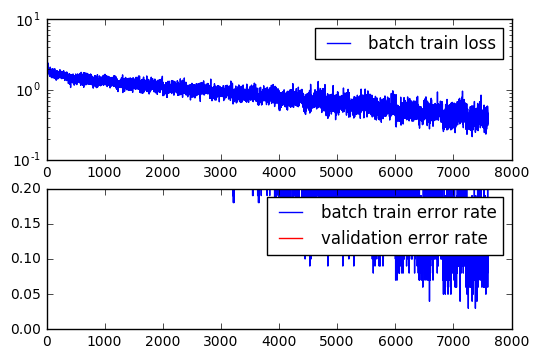

In [11]:
#
# TODO: pick a network architecture here. The one below is just 
# softmax regression
#

net = FeedForwardNet([
    AffineLayer(3072, 1000, weight_init=IsotropicGaussian(std=1.0/30.0)),
    ReLULayer(),
    AffineLayer(1000, 10, weight_init=IsotropicGaussian(std=1.0/30.0)),
    SoftMaxLayer()
])
SGD(net, cifar10_train_stream, cifar10_validation_stream, cifar10_test_stream)

print "Test error rate: %f" % (compute_error_rate(net, cifar10_test_stream), )